1. LIBRARIES

In [77]:
# 1. Data Manipulation & Analysis
import pandas as pd
import numpy as np

# 2. Visualization (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Machine Learning Pipeline & Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge

# 4. Model & Evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score

# 5. Model Persistence (Lưu trữ model)
import streamlit as st
import joblib


# Cấu hình hiển thị (Optional)
%matplotlib inline
sns.set(style="whitegrid")

2. DATA READING

In [61]:
df = pd.read_csv("/Users/lukesfolder/Desktop/diabetes/data/diabetes.csv")

In [62]:
def check_df(data, head=5):
    print("--SHAPE--")
    print(f'Shape          : {data.shape}\n'
          f'Size           : {data.size}\n'
          f'Missing values : {data.isnull().sum().sum()}\n'
          f'Duplicated     : {data.duplicated().sum()}')
check_df(df)

--SHAPE--
Shape          : (403, 19)
Size           : 7657
Missing values : 575
Duplicated     : 0


In [63]:
display(df.head())
df.describe()

,id,chol,stab.glu,hdl,ratio,glyhb,location,age,gender,height,weight,frame,bp.1s,bp.1d,bp.2s,bp.2d,waist,hip,time.ppn
0,1000,203.0,82,56.0,3.6,4.31,Buckingham,46,female,62.0,121.0,medium,118.0,59.0,NaN,NaN,29.0,38.0,720.0
1,1001,165.0,97,24.0,6.9,4.44,Buckingham,29,female,64.0,218.0,large,112.0,68.0,NaN,NaN,46.0,48.0,360.0
2,1002,228.0,92,37.0,6.2,4.64,Buckingham,58,female,61.0,256.0,large,190.0,92.0,185.0,92.0,49.0,57.0,180.0
3,1003,78.0,93,12.0,6.5,4.63,Buckingham,67,male,67.0,119.0,large,110.0,50.0,NaN,NaN,33.0,38.0,480.0
4,1005,249.0,90,28.0,8.9,7.72,Buckingham,64,male,68.0,183.0,medium,138.0,80.0,NaN,NaN,44.0,41.0,300.0


,id,chol,stab.glu,hdl,ratio,glyhb,age,height,weight,bp.1s,bp.1d,bp.2s,bp.2d,waist,hip,time.ppn
count,403.000000,402.000000,403.000000,402.000000,402.000000,390.000000,403.000000,398.000000,402.000000,398.000000,398.000000,141.000000,141.000000,401.000000,401.000000,400.000000
mean,15978.310174,207.845771,106.672457,50.445274,4.521642,5.589769,46.851117,66.020101,177.592040,136.904523,83.321608,152.382979,92.524823,37.900249,43.039900,341.250000
std,11881.122124,44.445557,53.076655,17.262626,1.727886,2.242595,16.312333,3.918515,40.340666,22.741033,13.589227,21.712952,11.555198,5.729313,5.656713,309.540953
min,1000.000000,78.000000,48.000000,12.000000,1.500000,2.680000,19.000000,52.000000,99.000000,90.000000,48.000000,110.000000,60.000000,26.000000,30.000000,5.000000
25%,4792.500000,179.000000,81.000000,38.000000,3.200000,4.380000,34.000000,63.000000,151.000000,121.250000,75.000000,138.000000,84.000000,33.000000,39.000000,90.000000
50%,15766.000000,204.000000,89.000000,46.000000,4.200000,4.840000,45.000000,66.000000,172.500000,136.000000,82.000000,149.000000,92.000000,37.000000,42.000000,240.000000
75%,20336.000000,230.000000,106.000000,59.000000,5.400000,5.600000,60.000000,69.000000,200.000000,146.750000,90.000000,161.000000,100.000000,41.000000,46.000000,517.500000
max,41756.000000,443.000000,385.000000,120.000000,19.299999,16.110001,92.000000,76.000000,325.000000,250.000000,124.000000,238.000000,124.000000,56.000000,64.000000,1560.000000


3. REPLACE MISSING VALUES WITH MEAN

In [64]:
detail_missing = pd.DataFrame({'Missing': df.isnull().sum(), 'Dtype': df.dtypes})
print('Detailed Missing Values:')
display(detail_missing[detail_missing['Missing'] > 0])

Detailed Missing Values:


,Missing,Dtype
chol,1,float64
hdl,1,float64
ratio,1,float64
glyhb,13,float64
height,5,float64
weight,1,float64
frame,12,object
bp.1s,5,float64
bp.1d,5,float64
bp.2s,262,float64


In [65]:
df_eda = df.copy()

# --- Bước 1: Phân loại cột dựa trên summary bạn đã tạo ---
# Lấy các cột là số (Numeric): int64, float64
num_cols = detail_missing[detail_missing['Dtype'].astype(str).str.contains('int|float')].index.tolist()

# Lấy các cột là chữ (Categorical): object, category
cat_cols = detail_missing[detail_missing['Dtype'] == 'object'].index.tolist()

# --- Bước 2: Xử lý cột SỐ (Numeric) ---
# Chỉ thay thế 0 bằng NaN cho các cột số
df_eda[num_cols] = df_eda[num_cols].replace(0, np.nan)

# Fillna bằng mean cho các cột số (Pandas tự khớp tên cột)
df_eda[num_cols] = df_eda[num_cols].fillna(df_eda[num_cols].mean())

# --- Bước 3: Xử lý cột PHÂN LOẠI (Categorical) ---
for col in cat_cols:
    if col in df_eda.columns:
        # Điền Mode cho từng cột phân loại
        df_eda[col] = df_eda[col].fillna(df_eda[col].mode()[0])

check_df(df_eda)

--SHAPE--
Shape          : (403, 19)
Size           : 7657
Missing values : 0
Duplicated     : 0


4. VISUALIZTION AND FEATURE SELECTION

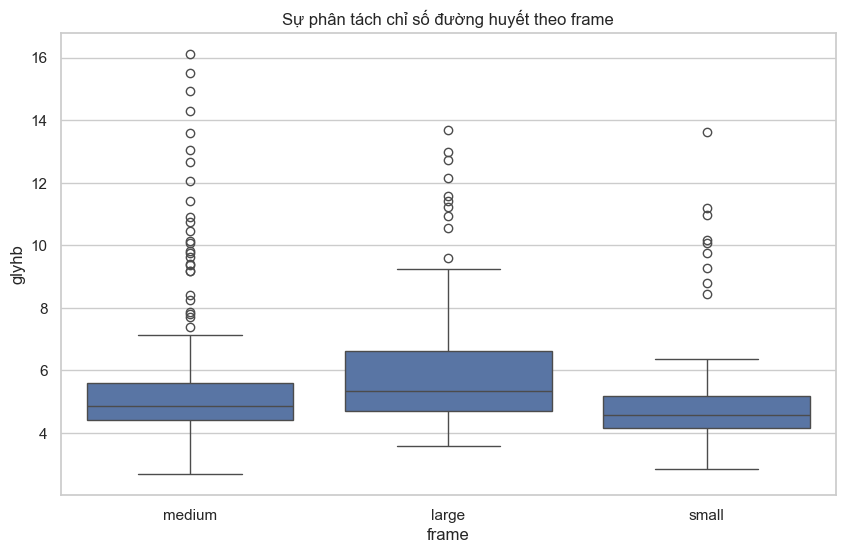

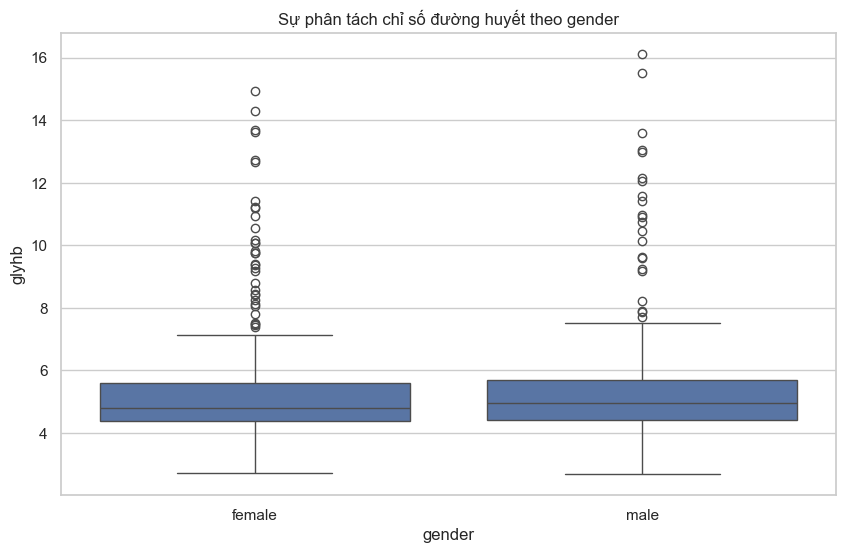

Kết luận: Chỉ số đường huyết không bị ảnh hưởng nhiều bởi các yếu tố phân loại.


In [66]:
for i in {'frame','gender'}: 
    plt.figure(figsize=(10,6))
    sns.boxplot(data=df_eda, x=i, y='glyhb')
    plt.title(f"Sự phân tách chỉ số đường huyết theo {i}")
    plt.show()
print("Kết luận: Chỉ số đường huyết không bị ảnh hưởng nhiều bởi các yếu tố phân loại.")

In [67]:
df_eda['weight'] = round(df_eda['weight'] /2.205,2)# pounds to kg
df_eda['height'] = round(df_eda['height'] * 2.54,2)  # inches to cm
df_eda['bmi'] = round(df_eda['weight'] / ((df_eda['height']/100) ** 2),2)
df_eda= df_eda.drop(['id', 'location','height','weight','bp.1s','bp.1d','bp.2s','bp.2d','time.ppn','gender','frame'], axis=1)

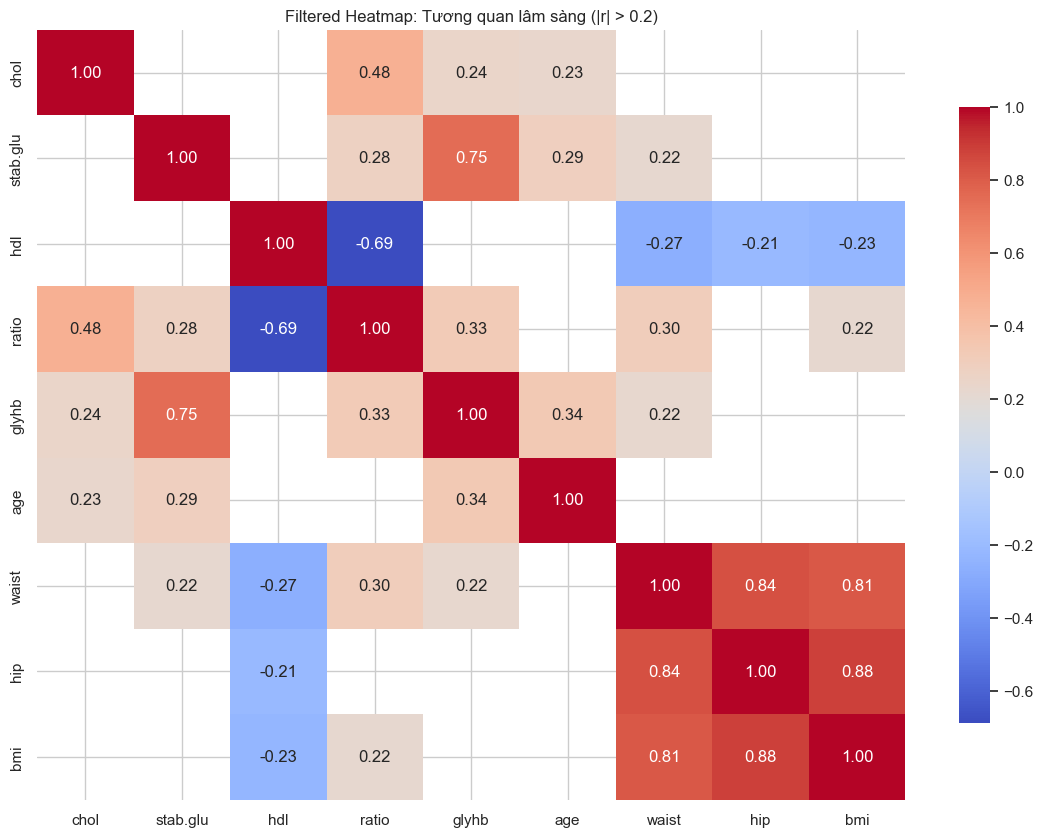

In [68]:
# 1. Tính ma trận tương quan của các cột quan trọng
corr = df_eda.corr(numeric_only=True)

# 2. Tạo Mask: Ẩn những giá trị nằm trong khoảng [-0.2, 0.2]
# Mask sẽ là True cho những ô mà bạn muốn GIẤU đi
mask = (corr > -0.2) & (corr < 0.2)

# 3. Vẽ Heatmap với tham số mask
plt.figure(figsize=(14, 10))

sns.heatmap(corr, 
            mask=mask,          # Áp dụng mặt nạ lọc dữ liệu
            annot=True,         # Hiện con số
            fmt=".2f",          # Làm tròn 2 chữ số
            cmap='coolwarm',    # Màu xanh (âm) - Trắng (0) - Đỏ (dương)
            cbar_kws={"shrink": .8}) # Thu nhỏ thanh thước đo màu

plt.title("Filtered Heatmap: Tương quan lâm sàng (|r| > 0.2)")
plt.show()

Mean               : 5.59
Median             : 4.87
Standard Deviation : 2.21


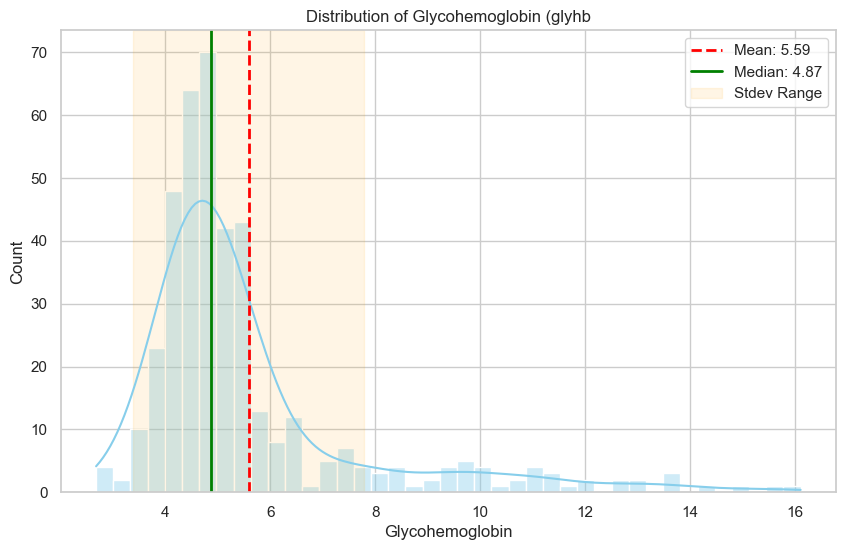

In [69]:
# 1. Calculate statistics
mean_val = df_eda['glyhb'].mean()
median_val = df_eda['glyhb'].median()
std_val = df_eda['glyhb'].std()
print(f'Mean               : {mean_val:.2f}')
print(f'Median             : {median_val:.2f}')
print(f'Standard Deviation : {std_val:.2f}')
# 2. Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_eda['glyhb'], kde=True, color='skyblue', alpha=0.4)

# 3. Add vertical lines for Mean and Median
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

# 4. Add Standard Deviation 
plt.axvspan(mean_val - std_val, mean_val + std_val, color='orange', alpha=0.1, label='Stdev Range')

# 5. Formatting
plt.title('Distribution of Glycohemoglobin (glyhb')
plt.xlabel('Glycohemoglobin')
plt.ylabel('Count')
plt.legend()
plt.show()

Mean               : 1.84
Median             : 1.77
Standard Deviation : 0.27


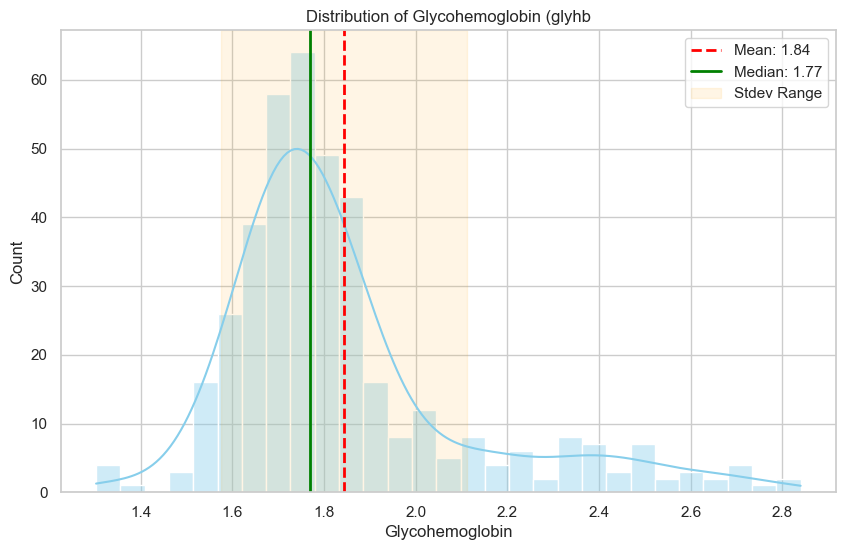

In [70]:
df_eda['log_glyhb'] = np.log1p(df_eda['glyhb']) # Logarithmic transformation to reduce skewness
# 1. Calculate statistics
mean_val_1 = df_eda['log_glyhb'].mean()
median_val_1 = df_eda['log_glyhb'].median()
std_val_1 = df_eda['log_glyhb'].std()
print(f'Mean               : {mean_val_1:.2f}')
print(f'Median             : {median_val_1:.2f}')
print(f'Standard Deviation : {std_val_1:.2f}')
# 2. Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_eda['log_glyhb'], kde=True, color='skyblue', alpha=0.4)

# 3. Add vertical lines for Mean and Median
plt.axvline(mean_val_1, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val_1:.2f}')
plt.axvline(median_val_1, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val_1:.2f}')

# 4. Add Standard Deviation 
plt.axvspan(mean_val_1 - std_val_1, mean_val_1 + std_val_1, color='orange', alpha=0.1, label='Stdev Range')
# 5. Formatting
plt.title('Distribution of Glycohemoglobin (glyhb')
plt.xlabel('Glycohemoglobin')
plt.ylabel('Count')
plt.legend()
plt.show()


5. SPLIT & TRAIN

In [71]:
# 1. Tách Features và Target
features = ['chol', 'stab.glu', 'hdl', 'ratio', 'age', 'waist', 'hip','bmi']  
X = df_eda[features]
y = df_eda['glyhb']

# 2. Chia tập dữ liệu (80% để học, 20% để kiểm tra)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape : {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape : {y_test.shape}")

X_train shape: (322, 8)
X_test shape : (81, 8)
y_train shape: (322,)
y_test shape : (81,)


In [72]:


# 1. Định nghĩa danh sách các mô hình dưới dạng Dictionary (Key: Tên, Value: Object)
models = {
    'Ridge': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
}

results = []

for name, model in models.items():
    # Tạo Pipeline cho từng mô hình
    model_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])

    # Huấn luyện và dự đoán
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)

    # Tính toán metric
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Lưu kết quả vào list
    results.append({
        'Model': name,
        'RMSE': round(rmse, 4),
        'R-squared': round(r2, 4),
        'Vs Baseline (%)': round((1 - rmse/std_val) * 100, 2)
    })

# 2. Hiển thị bảng so sánh bằng DataFrame
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print("Baseline STDEV", std_val)
results_df

Baseline STDEV 2.206035988310693


,Model,RMSE,R-squared,Vs Baseline (%)
0,Ridge,0.9835,0.8201,55.42
1,Random Forest,1.3517,0.6602,38.73
2,XGBoost,1.4157,0.6272,35.83


In [73]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# 1. Định nghĩa Pipeline cơ sở
base_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('regressor', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# 2. Thiết lập không gian tìm kiếm (Search Space)
# Lưu ý: tiền tố 'regressor__' là để chỉ định tham số cho bước regressor trong Pipeline
param_distributions = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0]
}

# 3. Chạy Randomized Search
# n_iter=50 nghĩa là máy sẽ thử 50 tổ hợp ngẫu nhiên
tuned_search = RandomizedSearchCV(
    base_pipeline, 
    param_distributions=param_distributions, 
    n_iter=50, 
    cv=5, 
    scoring='neg_root_mean_squared_error', 
    verbose=1, 
    random_state=42,
    n_jobs=-1, # Tận dụng đa nhân của chip M4
    error_score='raise'
)

tuned_search.fit(X_train, y_train)

# 4. Kết quả tốt nhất
best_rmse = -tuned_search.best_score_
print(f"\n--- Kết quả Fine-tuning ---")
print(f"Best CV RMSE.   : {best_rmse:.4f}")
print(f"Best Params.    : {tuned_search.best_params_}")

# 5. Đánh giá trên tập Test với mô hình tốt nhất
final_model = tuned_search.best_estimator_
y_pred_final = final_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))

print(f"Final Test RMSE : {final_rmse:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Kết quả Fine-tuning ---
Best CV RMSE.   : 1.5047
Best Params.    : {'regressor__subsample': 0.6, 'regressor__n_estimators': 200, 'regressor__max_depth': 10, 'regressor__learning_rate': 0.01, 'regressor__colsample_bytree': 1.0}
Final Test RMSE : 1.5070


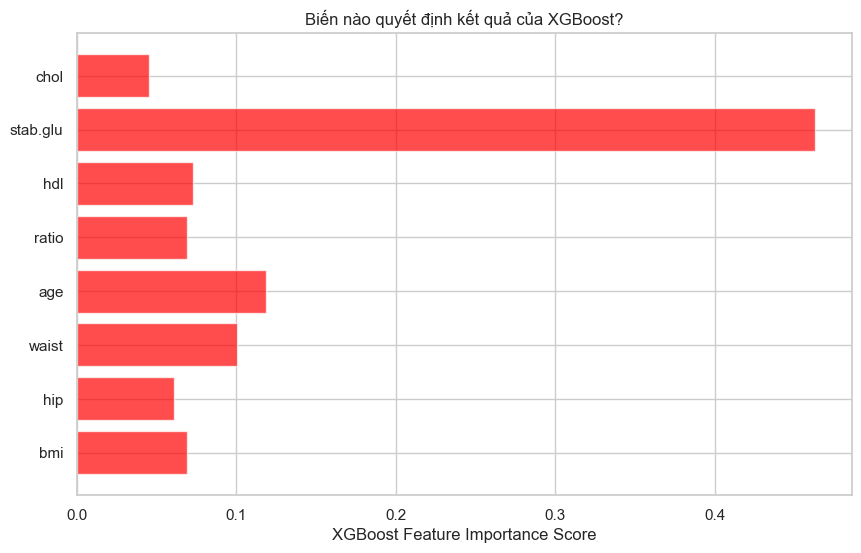

In [74]:
# 2. Trích xuất feature importances
importances = final_model.named_steps['regressor'].feature_importances_
feature_names = features # Danh sách ['chol', 'stab.glu', ...] của bạn

# 3. Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='red', alpha=0.7)
plt.xlabel("XGBoost Feature Importance Score")
plt.title("Biến nào quyết định kết quả của XGBoost?")
plt.gca().invert_yaxis() # Đảo ngược để biến quan trọng nhất nằm trên cùng
plt.show()

In [75]:
new_patient = {
    'chol': 200, 'stab.glu': 100, 'hdl': 50, 'ratio': 4.0, 
    'age': 50, 'waist': 85, 'hip': 90, 'bmi': 24.5
}

# Chuyển dict thành DataFrame và đảm bảo thứ tự cột giống features đã dùng khi huấn luyện
X_new = pd.DataFrame([new_patient])

# Dự đoán
Y_pred = final_model.predict(X_new)
if Y_pred[0] < 5.7:
    print(f"Dự đoán chỉ số Glyhb cho bệnh nhân mới: {Y_pred[0]:.2f} Bình thường")
elif 5.7 <= Y_pred[0] < 6.5: 
    print(f"Dự đoán chỉ số Glyhb cho bệnh nhân mới: {Y_pred[0]:.2f} Tiền Đái Tháo Đường")
else:
    print(f"Dự đoán chỉ số Glyhb cho bệnh nhân mới: {Y_pred[0]:.2f} Đái Tháo Đường")    


Dự đoán chỉ số Glyhb cho bệnh nhân mới: 5.96 Tiền Đái Tháo Đường


Tạo mô hình 

In [76]:
import joblib

# 1. LƯU MÔ HÌNH (Export)
# 'final_model' là cái 'best_estimator_' từ RandomizedSearchCV của bạn
model_filename = 'diabetes_xgb_model_v1.joblib'
joblib.dump(final_model, model_filename)

print(f"✅ Đã đóng gói mô hình vào file: {model_filename}")

# --- GIẢ SỬ BẠN TẮT MÁY, ĐI NGỦ, VÀ SÁNG MAI MỞ LẠI ---

# 2. TẢI MÔ HÌNH (Import)
loaded_model = joblib.load('diabetes_xgb_model_v1.joblib')
print("🚀 Đã tải mô hình lên thành công!")

# 3. KIỂM TRA THỬ (Test Prediction)
# Thử dự đoán với một dữ liệu giả lập
sample_data = pd.DataFrame([[200, 100, 50, 4.0, 40, 90, 95, 25.0]], 
                           columns=features) # Dùng lại danh sách features của bạn

result = loaded_model.predict(sample_data)
print(f"Dự đoán Glyhb cho ca mẫu: {result[0]:.2f}")

✅ Đã đóng gói mô hình vào file: diabetes_xgb_model_v1.joblib
🚀 Đã tải mô hình lên thành công!
Dự đoán Glyhb cho ca mẫu: 5.69
